In [3]:
import rasterio
import rasterio.features
import rasterio.warp

In [2]:
arquivo_raster = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/4_Códigos/Qualificação/14_106.tif'

In [12]:
with rasterio.open(arquivo_raster) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()
    banda1 = dataset.read(1)

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(geom)

{'type': 'Polygon', 'coordinates': [[[-46.573727, -23.518705], [-46.575232, -23.64482], [-46.394885, -23.646547], [-46.393552, -23.520422], [-46.573727, -23.518705]]]}


A dataset band is an array of values representing the partial distribution of a single variable in 2-dimensional (2D) space. All band arrays of a dataset have the same number of rows and columns.

In [4]:
dataset.width

631

In [5]:
dataset.height

479

Some dataset attributes expose the properties of all dataset bands via a tuple of values, one per band. To get a mapping of band indexes to variable data types, apply a dictionary comprehension to the zip() product of a dataset’s indexes and dtypes attributes.

In [6]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'float64'}

A GIS raster dataset is different from an ordinary image; its elements (or “pixels”) are mapped to regions on the earth’s surface. Every pixels of a dataset is contained within a spatial bounding box.

In [7]:
dataset.bounds

BoundingBox(left=339331.0, bottom=7384210.0, right=357730.3921, top=7398177.2089)

In [8]:
dataset.transform

Affine(29.1591, 0.0, 339331.0,
       0.0, -29.1591, 7398177.2089)

In [9]:
dataset.crs

CRS.from_epsg(31983)

In [10]:
dataset.indexes

(1,)

In [13]:
banda1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

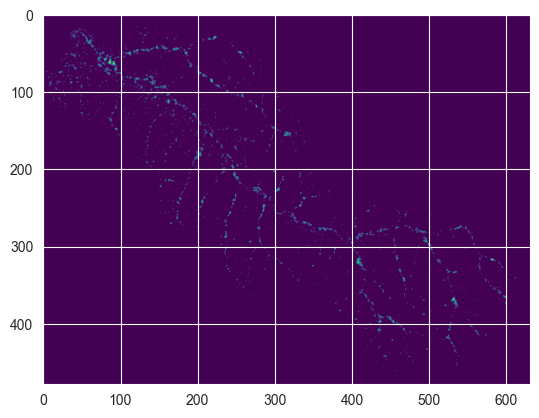

In [17]:
from matplotlib import pyplot as plt
dataset = rasterio.open(arquivo_raster)
plt.imshow(dataset.read(1), cmap='viridis')
plt.show()

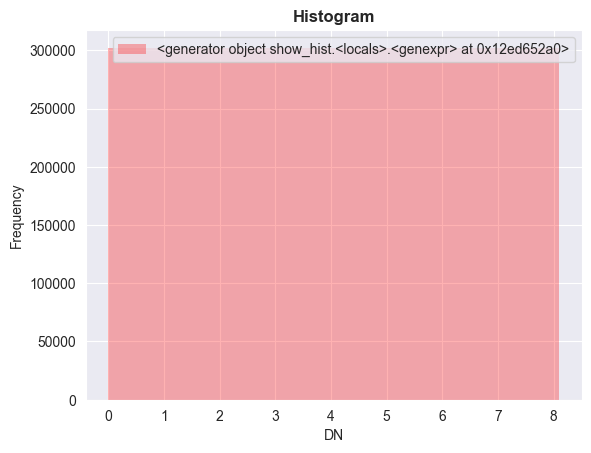

In [20]:
from rasterio.plot import show_hist
show_hist(
    dataset, bins=1, lw=0.0, stacked=False, alpha=0.3,
    histtype='stepfilled', title="Histogram")

In [21]:
dataset.shape

(479, 631)

In [22]:
dataset.dtypes

('float64',)

In [23]:
dataset.nodatavals

(None,)

In [24]:
dataset.nodata

In [25]:
msk = dataset.read_masks(1)
msk.shape
msk

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

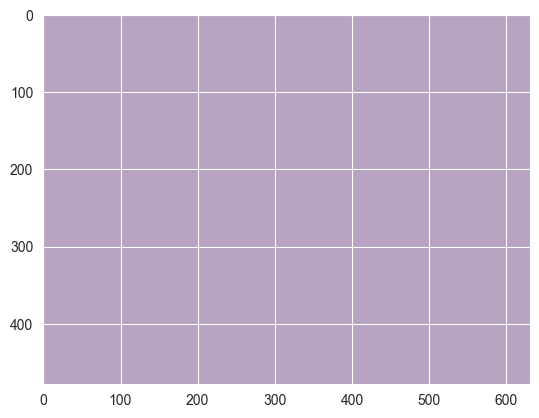

In [27]:
plt.imshow(msk, alpha=0.3, cmap='viridis')

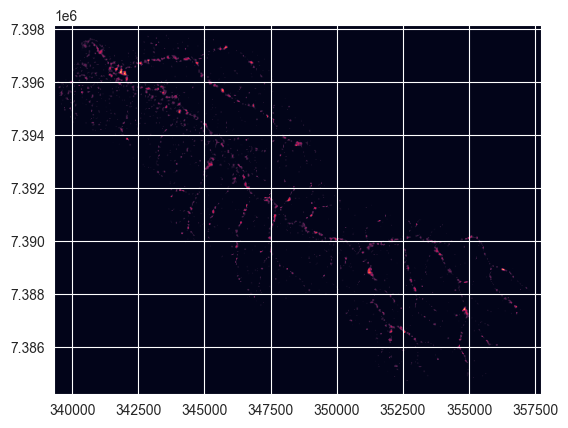

<Axes: >

In [28]:
rasterio.plot.show(dataset)

In [29]:
dataset.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 631,
 'height': 479,
 'count': 1,
 'crs': CRS.from_epsg(31983),
 'transform': Affine(29.1591, 0.0, 339331.0,
        0.0, -29.1591, 7398177.2089)}

In [4]:
import rasterio
import geopandas as gpd
import numpy as np
from shapely.geometry import Point

# Carregar o raster
with rasterio.open(arquivo_raster) as src:
    raster = src.read(1)
    transform = src.transform

# Identificar os pontos de alagamento
# Supondo que a altura mínima da lâmina de água para considerar alagamento é maior que zero
threshold = 0  # Defina o threshold conforme necessário
flood_points = np.argwhere(raster > threshold)

In [5]:
flood_points

array([[  5, 158],
       [  6, 155],
       [  6, 156],
       ...,
       [470, 531],
       [470, 532],
       [470, 533]])

In [6]:
import rasterio
import numpy as np

# Carregar o raster
with rasterio.open(arquivo_raster) as src:
    raster = src.read(1)

# Remover valores de no data se houver
no_data_value = src.nodata
if no_data_value is not None:
    raster = np.ma.masked_equal(raster, no_data_value)

# Calcular estatísticas descritivas
mean_value = np.mean(raster)
median_value = np.median(raster)
std_dev = np.std(raster)
min_value = np.min(raster)
max_value = np.max(raster)
percentiles = np.percentile(raster, [25, 50, 75])

# Exibir os resultados
print(f'Média: {mean_value}')
print(f'Mediana: {median_value}')
print(f'Desvio Padrão: {std_dev}')
print(f'Valor Mínimo: {min_value}')
print(f'Valor Máximo: {max_value}')
print(f'Percentil 25: {percentiles[0]}')
print(f'Percentil 50: {percentiles[1]}')
print(f'Percentil 75: {percentiles[2]}')


Média: 0.034789274770139864
Mediana: 0.0
Desvio Padrão: 0.28175393768145346
Valor Mínimo: 0.0
Valor Máximo: 8.102986
Percentil 25: 0.0
Percentil 50: 0.0
Percentil 75: 3e-06


In [7]:
import rasterio

# Carregar o raster
with rasterio.open(arquivo_raster) as src:
    # Exibir metadados
    print(src.meta)
    print(src.tags())


{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 631, 'height': 479, 'count': 1, 'crs': CRS.from_epsg(31983), 'transform': Affine(29.1591, 0.0, 339331.0,
       0.0, -29.1591, 7398177.2089)}
{'AREA_OR_POINT': 'Area'}


In [8]:
import rasterio

# Carregar o raster
with rasterio.open(arquivo_raster) as src:
    scale_factor = src.tags().get('scale_factor', 1)
    add_offset = src.tags().get('add_offset', 0)
    raster = src.read(1)
    # Aplicar escala e offset
    raster_converted = raster * float(scale_factor) + float(add_offset)

print(raster_converted)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
src.tags().get('scale_factor', 1)

ERROR 10: Pointer 'hObject' is NULL in 'GDALGetMetadata'.



1

In [10]:
from osgeo import gdal

# Abrir o raster
dataset = gdal.Open(arquivo_raster)
band = dataset.GetRasterBand(1)

# Obter a tabela de atributos
rat = band.GetDefaultRAT()
if rat:
    for i in range(rat.GetColumnCount()):
        print(rat.GetNameOfCol(i), rat.GetTypeOfCol(i))

    for row in range(rat.GetRowCount()):
        print([rat.GetValueAsString(row, col) for col in range(rat.GetColumnCount())])
else:
    print("Não há tabela de atributos associada.")


ModuleNotFoundError: No module named '_gdal'

In [ ]:

# Converter coordenadas de pixel para coordenadas geográficas
flood_geoms = [Point(rasterio.transform.xy(transform, row, col)) for row, col in flood_points]

# Criar um GeoDataFrame dos pontos de alagamento
flood_gdf = gpd.GeoDataFrame(geometry=flood_geoms)
flood_gdf['water_height'] = raster[flood_points[:, 0], flood_points[:, 1]]

# Transferir os valores de altura da lâmina de água para a rede viária
def get_max_water_height(line, flood_gdf):
    intersected_points = flood_gdf[flood_gdf.intersects(line)]
    if not intersected_points.empty:
        return intersected_points['water_height'].max()
    return 0

edges2['max_water_height'] = edges2['geometry'].apply(lambda line: get_max_water_height(line, flood_gdf))

# Salvar o GeoDataFrame atualizado
edges2.to_file('caminho/para/seu/edges2_com_agua.shp')


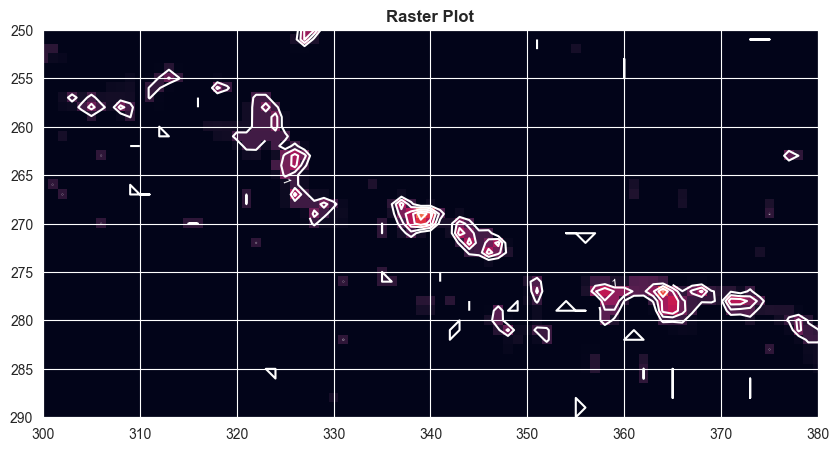

In [22]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show

# Abrir o raster e ler os dados
with rasterio.open(arquivo_raster) as src:
    raster = src.read(1)
    no_data_value = src.nodata
    
    # Se houver um valor de no data, mascará-lo
    if no_data_value is not None:
        raster = np.ma.masked_equal(raster, no_data_value)

    # Verificar e converter o tipo de dados do raster
    if raster.dtype.kind in 'UO':  # Se os dados forem unicode ou objeto, convertê-los
        raster = raster.astype(np.float32)
    else:
        raster = raster.astype(np.float32)  # Assegurar que os dados sejam float32 para plotagem

# Plotar o raster
fig, ax = plt.subplots(figsize=(10, 10))
show(raster, ax=ax, title='Raster Plot')

# Adicionar contornos
contours = ax.contour(raster, levels=np.arange(0,9, 1), colors='white')
ax.clabel(contours, inline=True, fontsize=8)

#Ajustar os limites dos eixos para dar zoom
ax.set_xlim(300,380)
ax.set_ylim(290,250)

plt.show()
